# Project - Predict the wellbeing of shanghainese communities

In [66]:
import pandas as pd
from matplotlib import pyplot
from shapely.geometry import Point, Polygon
from pandas.plotting import scatter_matrix
import numpy as np

In [67]:
df_target = pd.read_pickle("./dataset/TARGET-communities-extract-wellbeing.pkl")
header = df_target[0]
df_target = pd.DataFrame(data=df_target, columns=header)
df_target = df_target.drop(df_target.index[0])
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude
1,万寿社区居委会,3,0.0,0.0,盈浦街道,青浦区,121.104287016932,31.1558823799679
2,万泰花园第一居委会,3,1.0,0.0,七宝镇,闵行区,121.351529089795,31.144326843509
3,万科阳光苑居委会,2,0.0,0.0,吴泾镇,闵行区,121.468520387505,31.0422853979528
4,万豪居委会,3,0.0,0.0,长征镇,普陀区,121.367237458941,31.2407251034807
5,万里名轩社区居委会,2,,0.0,万里街道,普陀区,121.403601417271,31.269155049366


cleanliness (1-4, 4 best), smell (0-1,1 worst),  noise (0-1, 1 worst)

## Data types

In [68]:
df_target.dtypes

             object
clean        object
smell        object
noise        object
town         object
district     object
longitude    object
latitude     object
dtype: object

### Clean, smell, noise, longitude, latitude are consider as object: convert them into number type

In [69]:
df_target['clean'] = pd.to_numeric(df_target['clean'])
df_target['smell'] = pd.to_numeric(df_target['smell'])
df_target['noise'] = pd.to_numeric(df_target['noise'])
df_target['longitude'] = pd.to_numeric(df_target['longitude'])
df_target['latitude'] = pd.to_numeric(df_target['latitude'])

In [70]:
df_target.dtypes

              object
clean          int64
smell        float64
noise        float64
town          object
district      object
longitude    float64
latitude     float64
dtype: object

In [71]:
df_target['smell'] = df_target['smell'].apply(lambda x: 1 if x==0  else 0)
df_target['noise'] = df_target['noise'].apply(lambda x: 1 if x==0  else 0)
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude
1,万寿社区居委会,3,1,1,盈浦街道,青浦区,121.104287,31.155882
2,万泰花园第一居委会,3,0,1,七宝镇,闵行区,121.351529,31.144327
3,万科阳光苑居委会,2,1,1,吴泾镇,闵行区,121.468520,31.042285
4,万豪居委会,3,1,1,长征镇,普陀区,121.367237,31.240725
5,万里名轩社区居委会,2,0,1,万里街道,普陀区,121.403601,31.269155


cleanliness (1-4, 4 best), smell (0-1,0 worst),  noise (0-1, 0 worst)

In [72]:
df_target.describe()

,clean,smell,noise,longitude,latitude
count,467.000000,467.000000,467.000000,461.000000,461.000000
mean,2.556745,0.815846,0.781585,121.443524,31.213527
std,0.633890,0.388026,0.413614,0.113162,0.129333
min,1.000000,0.000000,0.000000,121.089976,30.736401
25%,2.000000,1.000000,1.000000,121.388639,31.163585
50%,3.000000,1.000000,1.000000,121.448259,31.228257
75%,3.000000,1.000000,1.000000,121.504818,31.281153
max,4.000000,1.000000,1.000000,121.892089,31.629071


## Target happiness

In [73]:
df_target['clean_coef'] = (df_target['clean']-1)/3*0.325
df_target['noise_coef'] = (df_target['noise']*0.325)
df_target['smell_coef'] = (df_target['smell']*0.35)
df_target['happiness'] = (df_target['smell_coef'] + df_target['noise_coef'] + df_target['clean_coef']) * 10
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude,clean_coef,noise_coef,smell_coef,happiness
1,万寿社区居委会,3,1,1,盈浦街道,青浦区,121.104287,31.155882,0.216667,0.325,0.35,8.916667
2,万泰花园第一居委会,3,0,1,七宝镇,闵行区,121.351529,31.144327,0.216667,0.325,0.00,5.416667
3,万科阳光苑居委会,2,1,1,吴泾镇,闵行区,121.468520,31.042285,0.108333,0.325,0.35,7.833333
4,万豪居委会,3,1,1,长征镇,普陀区,121.367237,31.240725,0.216667,0.325,0.35,8.916667
5,万里名轩社区居委会,2,0,1,万里街道,普陀区,121.403601,31.269155,0.108333,0.325,0.00,4.333333


In [74]:
geometry = [Point(xy) for xy in zip(df_target['longitude'], df_target['latitude'])]

In [75]:
df_target['geometry'] = geometry

In [151]:
df_target.head()

,,clean,smell,noise,town,district,longitude,latitude,clean_coef,noise_coef,smell_coef,happiness,geometry
1,万寿社区居委会,3,1,1,盈浦街道,青浦区,121.104287,31.155882,0.216667,0.325,0.35,8.916667,POINT (121.104287016932 31.1558823799679)
2,万泰花园第一居委会,3,0,1,七宝镇,闵行区,121.351529,31.144327,0.216667,0.325,0.00,5.416667,POINT (121.351529089795 31.144326843509)
3,万科阳光苑居委会,2,1,1,吴泾镇,闵行区,121.468520,31.042285,0.108333,0.325,0.35,7.833333,POINT (121.468520387505 31.0422853979528)
4,万豪居委会,3,1,1,长征镇,普陀区,121.367237,31.240725,0.216667,0.325,0.35,8.916667,POINT (121.367237458941 31.2407251034807)
5,万里名轩社区居委会,2,0,1,万里街道,普陀区,121.403601,31.269155,0.108333,0.325,0.00,4.333333,POINT (121.403601417271 31.269155049366)


## Check is the point of target is in the discrict

In [77]:
df_district = pd.read_pickle("./dataset/utseus-cendus-shanghai-neighborhoods.pk")

In [78]:
happiness = {}
total = 0
sum_happiness = 0
for index, polygon in df_district['geometry'].items():
    for happy, point in zip(df_target['happiness'], df_target['geometry']):
        if point.within(polygon) == True:
            sum_happiness += happy
            total += 1
    if total != 0 : 
        happiness[index] = sum_happiness/total
    else:
        happiness[index] = 0
    sum_mean = 0
    total = 0

In [152]:
df_model = df_district[['geometry']].copy()

In [153]:
df_model.head()

,geometry
0,"POLYGON Z ((121.42168 30.68471 0.00000, 121.42..."
1,"POLYGON Z ((121.41199 30.69374 0.00000, 121.41..."
2,"POLYGON Z ((121.40163 30.70717 0.00000, 121.40..."
3,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33..."
4,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25..."


In [154]:
df_model['happiness'] = happiness.values()
df_model.head()

,geometry,happiness
0,"POLYGON Z ((121.42168 30.68471 0.00000, 121.42...",0.0
1,"POLYGON Z ((121.41199 30.69374 0.00000, 121.41...",0.0
2,"POLYGON Z ((121.40163 30.70717 0.00000, 121.40...",0.0
3,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33...",0.0
4,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25...",0.0


# Features

## POI

In [82]:
df_poi = pd.read_pickle("./variables/poi_per_district.pkl")
df_poi.head()

,geometry,nb_transportation,nb_shopping,nb_restaurant,nb_scenicSpot,nb_stadiumAndGym
0,"POLYGON Z ((121.42168 30.68471 0.00000, 121.42...",0,0,0,0,0
1,"POLYGON Z ((121.41199 30.69374 0.00000, 121.41...",0,0,0,0,0
2,"POLYGON Z ((121.40163 30.70717 0.00000, 121.40...",0,0,0,0,0
3,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33...",1087,1789,748,28,32
4,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25...",1428,1762,616,9,12


In [155]:
df_features = df_poi.copy()

## Green Space

In [84]:
df_greenspace = pd.read_pickle("./variables/greenspaces_per_district.pickle")
df_greenspace.head()

,new_geometry,green_area,green_area_proportion
35,"POLYGON ((121.44356 31.00937, 121.44338 31.009...",0.000076,0.026719
47,"POLYGON ((121.38734 31.03991, 121.38699 31.040...",0.000001,0.000759
48,"POLYGON ((121.42360 31.07339, 121.42303 31.073...",0.000004,0.001591
50,"POLYGON ((121.45789 31.10380, 121.45879 31.101...",0.000072,0.020270
53,"POLYGON ((121.46062 31.11422, 121.46045 31.113...",0.000058,0.083765


In [158]:
df_features.insert(6,'green_area_proportion', df_greenspace.green_area_proportion)

## Mobike 

In [ ]:
df_mobike = pd.read_pickle("./variables/mobike_per_district.pickle")
df_mobike.head()

In [ ]:
df_features.insert(7,'nb_mobike', df_mobike.nb_mobike)

# Clean features

In [162]:
# Drop row where all the features are null
columns = ['nb_transportation', 'nb_shopping', 'nb_restaurant', 'nb_scenicSpot', 'nb_stadiumAndGym', 'green_area_proportion']
df_features = df_features.replace(0, pd.np.nan).dropna(axis=0, how='all', subset=columns)

In [168]:
df_features[columns] = df_features[columns].fillna(0).astype(float)

In [171]:
df_features.reset_index()

,index,geometry,nb_transportation,nb_shopping,nb_restaurant,nb_scenicSpot,nb_stadiumAndGym,green_area_proportion
0,3,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33...",1087.0,1789.0,748.0,28.0,32.0,0.0
1,4,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25...",1428.0,1762.0,616.0,9.0,12.0,0.0
2,5,"POLYGON Z ((121.36179 30.80039 0.00000, 121.36...",1622.0,2152.0,1131.0,14.0,28.0,0.0
3,6,"POLYGON Z ((121.19465 30.81453 0.00000, 121.19...",492.0,197.0,86.0,9.0,4.0,0.0
4,7,"POLYGON Z ((121.29682 30.81891 0.00000, 121.29...",835.0,374.0,177.0,12.0,7.0,0.0
...,...,...,...,...,...,...,...,...
243,261,"POLYGON Z ((121.18624 31.80997 0.00000, 121.18...",302.0,18.0,15.0,4.0,0.0,0.0
244,262,"POLYGON Z ((121.40581 31.79716 0.00000, 121.40...",7.0,0.0,0.0,0.0,0.0,0.0
245,263,"POLYGON Z ((121.24444 31.84448 0.00000, 121.24...",230.0,28.0,17.0,1.0,0.0,0.0
246,264,"POLYGON Z ((121.26771 31.84871 0.00000, 121.26...",1.0,0.0,0.0,0.0,0.0,0.0


# Modeling

In [172]:
df_model = pd.merge(df_model, df_features, left_on='geometry', right_on='geometry')

In [173]:
df_model.head()

,geometry,happiness,nb_transportation,nb_shopping,nb_restaurant,nb_scenicSpot,nb_stadiumAndGym,green_area_proportion
0,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33...",0.000000,1087.0,1789.0,748.0,28.0,32.0,0.0
1,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25...",0.000000,1428.0,1762.0,616.0,9.0,12.0,0.0
2,"POLYGON Z ((121.36179 30.80039 0.00000, 121.36...",8.916667,1622.0,2152.0,1131.0,14.0,28.0,0.0
3,"POLYGON Z ((121.19465 30.81453 0.00000, 121.19...",0.000000,492.0,197.0,86.0,9.0,4.0,0.0
4,"POLYGON Z ((121.29682 30.81891 0.00000, 121.29...",9.277778,835.0,374.0,177.0,12.0,7.0,0.0


In [174]:
df_model.shape

(248, 8)

248 observations and 7 features

### Save model pickle

In [175]:
df_model.to_pickle("./df_model.pickle")

### Load model pickle

In [147]:
df_model = pd.read_pickle("df_model.pickle")

## Classification

In [176]:
df_model.columns

Index(['geometry', 'happiness', 'nb_transportation', 'nb_shopping',
       'nb_restaurant', 'nb_scenicSpot', 'nb_stadiumAndGym',
       'green_area_proportion'],
      dtype='object')

## Scale features

In [177]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #scaler like 'centré réduit'
# Fit: select some columns, it's expecting more than one column so u need to write like this [[]]
df_model['nb_transportation_scaled'] = scaler.fit_transform(df_model[['nb_transportation']])
df_model['nb_shopping_scaled'] = scaler.fit_transform(df_model[['nb_shopping']])
df_model['nb_restaurant_scaled'] = scaler.fit_transform(df_model[['nb_restaurant']])
df_model['nb_scenicSpot_scaled'] = scaler.fit_transform(df_model[['nb_scenicSpot']])
df_model['nb_stadiumAndGym_scaled'] = scaler.fit_transform(df_model[['nb_stadiumAndGym']])
df_model['green_area_proportion_scaled'] = scaler.fit_transform(df_model[['green_area_proportion']])

In [178]:
print(scaler.mean_)

[0.02211763]


In [180]:
df_model.head()

,geometry,happiness,nb_transportation,nb_shopping,nb_restaurant,nb_scenicSpot,nb_stadiumAndGym,green_area_proportion,nb_transportation_scaled,nb_shopping_scaled,nb_restaurant_scaled,nb_scenicSpot_scaled,nb_stadiumAndGym_scaled,green_area_proportion_scaled
0,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33...",0.000000,1087.0,1789.0,748.0,28.0,32.0,0.0,0.142085,0.213356,-0.195755,0.142784,0.016965,-0.50485
1,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25...",0.000000,1428.0,1762.0,616.0,9.0,12.0,0.0,0.586952,0.195711,-0.347412,-0.395885,-0.592775,-0.50485
2,"POLYGON Z ((121.36179 30.80039 0.00000, 121.36...",8.916667,1622.0,2152.0,1131.0,14.0,28.0,0.0,0.840043,0.450578,0.244278,-0.254130,-0.104983,-0.50485
3,"POLYGON Z ((121.19465 30.81453 0.00000, 121.19...",0.000000,492.0,197.0,86.0,9.0,4.0,0.0,-0.634149,-0.827023,-0.956335,-0.395885,-0.836670,-0.50485
4,"POLYGON Z ((121.29682 30.81891 0.00000, 121.29...",9.277778,835.0,374.0,177.0,12.0,7.0,0.0,-0.186673,-0.711353,-0.851784,-0.310832,-0.745209,-0.50485


## Split data into training and test sets

In [181]:
X = df_model[['nb_transportation', 'nb_shopping', 'nb_restaurant', 'nb_scenicSpot', 'nb_stadiumAndGym', 'green_area_proportion']] #features
Y = df_model['happiness'] #target

In [182]:
Z = pd.DataFrame.copy(Y)
Z[Y <= np.median(Y)] = "Unhappy"
Z[Y > np.median(Y)] = "Happy"

In [183]:
df_model['class'] = Z

In [184]:
df_model.groupby('class').size()

class
Happy      124
Unhappy    124
dtype: int64

## Explore the data

### Hist

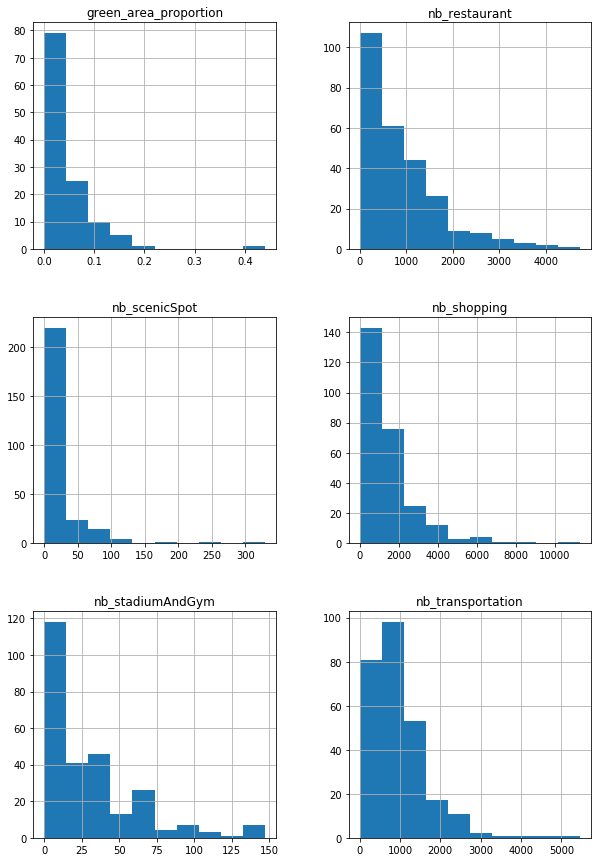

In [98]:
X.hist(figsize=(10,15))
pyplot.show()

## Scatter Matrix Plot for each input variables: show how much one variable is affected by another

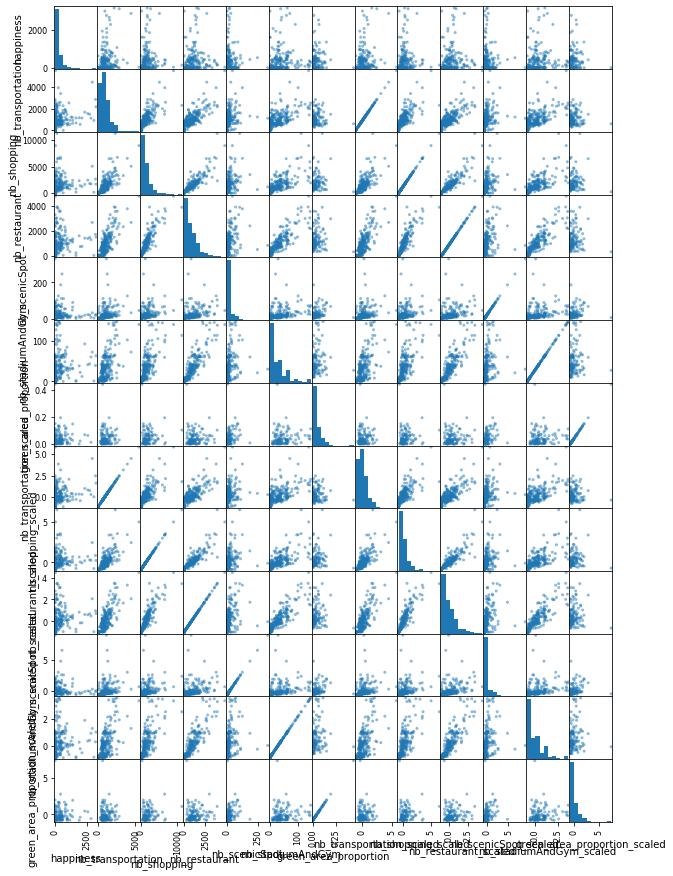

In [99]:
# scatter plot matrix
scatter_matrix(df_model, figsize=(10,15))
pyplot.show()

## Split data into training and test sets

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, Z_train, Z_test = train_test_split(X, Z, test_size=0.3, random_state=123, stratify=Z)

In [102]:
df_model

,geometry,happiness,nb_transportation,nb_shopping,nb_restaurant,nb_scenicSpot,nb_stadiumAndGym,green_area_proportion,nb_transportation_scaled,nb_shopping_scaled,nb_restaurant_scaled,nb_scenicSpot_scaled,nb_stadiumAndGym_scaled,green_area_proportion_scaled,class
0,"POLYGON Z ((121.42168 30.68471 0.00000, 121.42...",0.0,0,0,0,0,0,NaN,-1.169345,-0.895594,-0.982479,-0.619804,-0.898112,NaN,Unhappy
1,"POLYGON Z ((121.41199 30.69374 0.00000, 121.41...",0.0,0,0,0,0,0,NaN,-1.169345,-0.895594,-0.982479,-0.619804,-0.898112,NaN,Unhappy
2,"POLYGON Z ((121.40163 30.70717 0.00000, 121.40...",0.0,0,0,0,0,0,NaN,-1.169345,-0.895594,-0.982479,-0.619804,-0.898112,NaN,Unhappy
3,"POLYGON Z ((121.33687 30.73806 0.00000, 121.33...",0.0,1087,1789,748,28,32,NaN,0.224530,0.279438,-0.124195,0.190784,0.082233,NaN,Unhappy
4,"POLYGON Z ((121.25143 30.79177 0.00000, 121.25...",0.0,1428,1762,616,9,12,NaN,0.661799,0.261704,-0.275657,-0.359258,-0.530483,NaN,Unhappy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,"POLYGON Z ((121.18624 31.80997 0.00000, 121.18...",0.0,302,18,15,4,0,NaN,-0.782086,-0.883771,-0.965268,-0.504006,-0.898112,NaN,Unhappy
262,"POLYGON Z ((121.40581 31.79716 0.00000, 121.40...",0.0,7,0,0,0,0,NaN,-1.160368,-0.895594,-0.982479,-0.619804,-0.898112,NaN,Unhappy
263,"POLYGON Z ((121.24444 31.84448 0.00000, 121.24...",0.0,230,28,17,1,0,NaN,-0.874412,-0.877203,-0.962973,-0.590855,-0.898112,NaN,Unhappy
264,"POLYGON Z ((121.26771 31.84871 0.00000, 121.26...",0.0,1,0,0,0,0,NaN,-1.168062,-0.895594,-0.982479,-0.619804,-0.898112,NaN,Unhappy


## Grid Search: find the best parameters for the model

In [42]:
from sklearn.model_selection import GridSearchCV

## 1. K-Nearest Neighbors - KNN

## 2. Support Vector Machines - SVM

## Evaluate each model

In [ ]:
models = []

In [ ]:
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(gamma='auto')))

In [ ]:
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))